[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/04_pytorch_for_tabular_data.ipynb)


## **Predicting second hand car price from Rodkaidee: Regression**

This notebook contains the following steps for predicting second hand car price from [Rodkaidee website](https://rod.kaidee.com/)

- Import libraries
- Prepare data: Categorical and numerical features
- Train linear regression model
- Train one-layer neural network model for regression (equivalent to linear regression)
- Train multi-layer neural network model for regression

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

c:\Anaconda3\envs\ocr\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Anaconda3\envs\ocr\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Anaconda3\envs\ocr\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## **Data Preparation**

In [35]:
# !pip install openpyxl

# df = pd.read_excel("Rodkaidee Data.xlsx", engine="openpyxl")
df = pd.read_csv("Rodkaidee Data.csv")
df.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
0,Mazda,Mazda2,1.3,B-Segment,2022,"15,640",กรุงเทพมหานคร,"499,000",Gray
1,Suzuki,Celerio,1.0,Eco Car,2021,"9,545",กรุงเทพมหานคร,"315,000",White
2,Mitsubishi,Mirage,1.2,Eco Car,2021,"10,900",นนทบุรี,"335,000",Gray
3,Nissan,March,1.2,Eco Car,2021,"12,000",กรุงเทพมหานคร,"339,000",Silver
4,Mitsubishi,Attrage,1.2,Eco Car,2021,"25,706",กาญจนบุรี,"350,000",Gray


**Apply One-hot Encoding to categorical values**

For example, if a column has three unique values 'A', 'B', and 'C', rows that contain 'C' will be transformed to [0, 0, 1] .

In [36]:
from sklearn.preprocessing import OneHotEncoder

CATEGORICAL_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
NUMERIC_COLUMNS = ["Year", "Mileage"]

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_train_array = ohe.fit_transform(df[CATEGORICAL_COLUMNS])
cat_test_array = ohe.transform(df[CATEGORICAL_COLUMNS])

**Normalize continuous values**

For example, column X has values from 0 to 1000000, so we need to normalize them to 0 to 1

In [37]:
from sklearn.preprocessing import MinMaxScaler

df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))


year_scaler = MinMaxScaler()
mileage_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

df["Year"] = year_scaler.fit_transform(df[["Year"]])
df["Mileage"] = mileage_scaler.fit_transform(df[["Mileage"]])
df["Price"] = price_scaler.fit_transform(df[["Price"]])

### Wrap everything up as a single function

In [61]:
CATEGORICAL_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
NUMERIC_COLUMNS = ["Year", "Mileage"]

def preprocess_dataframe(
    dataframe: pd.DataFrame,
    one_hot_encoder: OneHotEncoder,
    scaler_dictionary: dict = None,
    ) -> pd.DataFrame:

    cat_feature_array = one_hot_encoder.transform(dataframe[CATEGORICAL_COLUMNS])

    scaled_feature_list = []
    for col in NUMERIC_COLUMNS:
        scaled_feature_array = scaler_dictionary[col].transform(dataframe[[col]])
        scaled_feature_list.append(scaled_feature_array)
    numeric_feature_array = np.hstack(scaled_feature_list)

    preprocessed_feature_array = np.hstack((cat_feature_array, numeric_feature_array))
    return preprocessed_feature_array

## **Train a simple Linear Regression Model**

In [124]:
import os.path as op
# Split the data into train and test sets.
data_path = "Rodkaidee Data.csv"
df = pd.read_csv(data_path)
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [125]:
# Create the encoder and scaler objects. These should actually be fitted only on the training data.
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
year_scaler = MinMaxScaler()
mileage_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

# Fit the encoder and scaler objects on the training data.
ohe.fit(df[CATEGORICAL_COLUMNS])
year_scaler.fit(df_train[["Year"]])
mileage_scaler.fit(df_train[["Mileage"]])
price_scaler.fit(df_train[["Price"]])

# Save the encoder and scaler objects.
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(ohe, op.join(save_dir, "one_hot_encoder.joblib"))
joblib.dump(year_scaler, op.join(save_dir, "year_scaler.joblib"))
joblib.dump(mileage_scaler, op.join(save_dir, "mileage_scaler.joblib"))
joblib.dump(price_scaler, op.join(save_dir, "price_scaler.joblib"))

['trained_models\\price_scaler.joblib']

In [126]:
scaler_dict = {
    "Year": year_scaler,
    "Mileage": mileage_scaler,
    "Price": price_scaler,
}

x_train = preprocess_dataframe(df_train, one_hot_encoder=ohe, scaler_dictionary = scaler_dict)
y_train = scaler_dict["Price"].transform(df_train[["Price"]])

In [127]:
# Fit a linear regression model to the training data.
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [128]:
x_test = preprocess_dataframe(df_test, one_hot_encoder=ohe, scaler_dictionary = scaler_dict)
y_test = scaler_dict["Price"].transform(df_test[["Price"]])

predictions = lr_model.predict(x_test)
predictions.shape

(1480, 1)

### Evaluate the model on the test set with Mean Squared Error

In [129]:
# Calculate the mean squared error.
mean_squared_error(predictions, y_test)

1.9338031533663199e+18

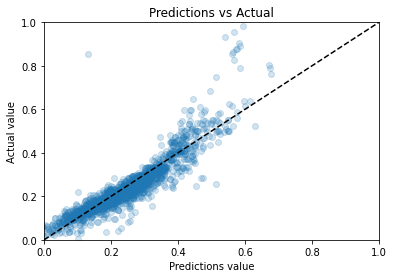

In [130]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.Figure(figsize=(10, 10))
plt.scatter(predictions, y_test, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [131]:
joblib.dump(lr_model, "trained_models/carprice_model_linear_regression.joblib")

['trained_models/carprice_model_linear_regression.joblib']

## **Train a simple Neural Network**

In [74]:
from torch.utils.data import Dataset, DataLoader

class CarPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [77]:
data_path = "Rodkaidee Data.csv"
one_hot_encoder_path = "trained_models/one_hot_encoder.joblib"
one_hot_encoder = joblib.load(one_hot_encoder_path)

scaler_dict = {
    "Year": joblib.load("trained_models/year_scaler.joblib"),
    "Mileage": joblib.load("trained_models/mileage_scaler.joblib"),
    "Price": joblib.load("trained_models/price_scaler.joblib"),
}

In [79]:
df = pd.read_csv(data_path)
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

x_train = preprocess_dataframe(
    df_train,
    one_hot_encoder = one_hot_encoder,
    scaler_dictionary = scaler_dict,
    )
y_train = scaler_dict["Price"].transform(df_train[["Price"]])
y_train = y_train.reshape(-1, 1)

x_test = preprocess_dataframe(
    df_test,
    one_hot_encoder = one_hot_encoder,
    scaler_dictionary = scaler_dict,
)
y_test = scaler_dict["Price"].transform(df_test[["Price"]])
y_test = y_test.reshape(-1, 1)
print(x_train.shape, y_train.shape)

(5918, 139) (5918, 1)


In [80]:
train_dataset = CarPriceDataset(x_train, y_train)
test_dataset = CarPriceDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# x_sample, y_sample = next(iter(train_dataloader))
# x_sample, y_sample

In [81]:
class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [82]:
model = CarPriceModel(input_size=x_train.shape[1], output_size=y_train.shape[1])
model

CarPriceModel(
  (linear): Linear(in_features=139, out_features=1, bias=True)
)

In [85]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn = nn.MSELoss(reduction='mean'),
    num_epochs = 100,
    update_frequency = 10,
    ):
    for epoch in tqdm(range(num_epochs)):
        # Set the model to training mode.
        model.train()
        for x, y in train_dataloader:
            # Forward pass.
            y_pred = model(x.float())
            # Calculate the loss.
            loss = loss_fn(y_pred, y.float())
            # Backward pass.
            loss.backward()
            # Update the model parameters.
            optimizer.step()
            # Reset the gradients.
            optimizer.zero_grad()

        # Set the model to evaluation mode and calculate the test loss at the end of each epoch.
        model.eval()
        with torch.no_grad():
            for x, y in test_dataloader:
                # Forward pass.
                y_pred = model(x.float())
                # Calculate the loss.
                loss = loss_fn(y_pred, y.float())

            # Print the loss if the epoch is a multiple of 10.
            if epoch % update_frequency == 0:
                print(f"Epoch {epoch}: {loss.item()}")

def predict(model, test_dataloader):
    model.eval()
    prediction_list = []
    actual_y_list = []
    for x, y in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y = y.numpy()
        prediction_list.append(prediction)
        actual_y_list.append(y)
    return prediction_list, actual_y_list

In [86]:
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.001
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = num_epochs,
    update_frequency = update_frequency,
    )

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.003363352967426181
Epoch 10: 0.001201561070047319
Epoch 20: 0.0009836956160143018
Epoch 30: 0.0019843983463943005
Epoch 40: 0.001322674797847867
Epoch 50: 0.0017028943402692676
Epoch 60: 0.0012213578447699547
Epoch 70: 0.0016371775418519974
Epoch 80: 0.0016547015402466059
Epoch 90: 0.001410448458045721
Epoch 100: 0.0015030113281682134
Epoch 110: 0.0012209414271637797


### Evaluate the model on the test set with Mean Squared Error

In [87]:
# Get the predictions for the test set.
prediction_list, actual_y_list = predict(model, test_dataloader)

In [88]:
actual_y_array = np.concatenate(actual_y_list)
prediction_array = np.concatenate(prediction_list)
mean_squared_error(prediction_array, actual_y_array)

0.0032026244920527664

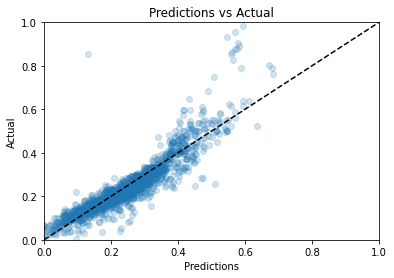

In [99]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(prediction_array, actual_y_array, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [100]:
torch.save(model.state_dict(), "trained_models/carprice_model_mse_003.pth")

## **Train a Neural Network with multiple layers (MLP)**

In [101]:
class CarPriceDoubleModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

double_model = CarPriceDoubleModel(input_size=x_train.shape[1], output_size=y_train.shape[1])

In [102]:
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.001
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(double_model.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model = double_model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = num_epochs,
    update_frequency = update_frequency,
    )

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.019071556627750397
Epoch 10: 0.0020865602418780327
Epoch 20: 0.0015041530132293701
Epoch 30: 0.0011783149093389511
Epoch 40: 0.001694084145128727
Epoch 50: 0.0007723381859250367
Epoch 60: 0.001313975197263062
Epoch 70: 0.0013191686011850834
Epoch 80: 0.00105943507514894
Epoch 90: 0.0014375465689226985
Epoch 100: 0.0012544584460556507
Epoch 110: 0.0012795061338692904


In [104]:
prediction_list, actual_y_list = predict(double_model, test_dataloader)
prediction_array = np.concatenate(prediction_list)
actual_y_array = np.concatenate(actual_y_list)
mse_score = mean_squared_error(prediction_array, actual_y_array)
mse_score

0.0022745948065439883

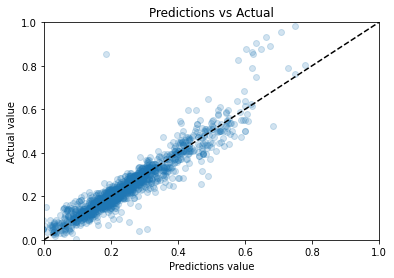

In [105]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(prediction_array, actual_y_array, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [107]:
mse_identifier = round(mse_score, 5)
mse_identifier = str(mse_identifier).replace(".", "")

torch.save(double_model.state_dict(), f"trained_models/carprice_double_model_mse_{mse_identifier}.pth")

## **Use the models to predict on new data**

In [113]:
CATEGORICAL_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
NUMERIC_COLUMNS = ["Year", "Mileage"]

class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

def preprocess_dataframe(
    dataframe: pd.DataFrame,
    one_hot_encoder : OneHotEncoder,
    scaler_dictionary: dict,
    ) -> pd.DataFrame:
    """
    Preprocesses a dataframe by applying one-hot encoding to the categorical columns and scaling the numeric columns.
    """
    # Apply one-hot encoding to categorical columns.
    cat_feature_array = one_hot_encoder.transform(dataframe[CATEGORICAL_COLUMNS])

    # Scale numeric values to be between 0 and 1.
    scaled_feature_list = []
    for col in NUMERIC_COLUMNS:
        scaled_feature_array = scaler_dictionary[col].transform(dataframe[[col]])
        scaled_feature_list.append(scaled_feature_array)
    # Concatenate the numeric features.
    numeric_feature_array = np.hstack(scaled_feature_list)

    # Concatenate the categorical features and the numeric features.
    preprocessed_feature_array = np.hstack((cat_feature_array, numeric_feature_array))
    return preprocessed_feature_array

@torch.no_grad()
def pytorch_predict_car_price(
    dataframe: pd.DataFrame,
    model: CarPriceModel,
    one_hot_encoder : OneHotEncoder,
    scaler_dictionary: dict,
    ) -> float:
    """
    Predicts car price from a dataframe with the given pytorch model.
    """
    model.eval()
    preprocessed_feature_array = preprocess_dataframe(
        dataframe = dataframe,
        one_hot_encoder=one_hot_encoder,
        scaler_dictionary=scaler_dictionary,
        )
    preprocessed_feature_tensor = torch.from_numpy(preprocessed_feature_array)
    prediction_tensor = model(preprocessed_feature_tensor.float())
    prediction_array = prediction_tensor.detach().numpy()
    # Scale the prediction back to the original scale.
    prediction_array = scaler_dictionary["Price"].inverse_transform(prediction_array)
    return prediction_array


def sklearn_predict_car_price(
    dataframe: pd.DataFrame,
    sklearn_model: LinearRegression,
    one_hot_encoder : OneHotEncoder,
    scaler_dictionary: dict,
    ) -> float:
    """
    Predicts car price from a dataframe with the given sklearn model.
    """
    preprocessed_feature_array = preprocess_dataframe(
        dataframe = dataframe,
        one_hot_encoder=one_hot_encoder,
        scaler_dictionary=scaler_dictionary,
        )
    prediction_array = sklearn_model.predict(preprocessed_feature_array)
    # Scale the prediction back to the original scale.
    prediction_array = scaler_dictionary["Price"].inverse_transform(prediction_array)
    return prediction_array

In [114]:
data_path = "Rodkaidee Data.csv"
one_hot_encoder_path = "trained_models/one_hot_encoder.joblib"
year_scaler_path = "trained_models/year_scaler.joblib"
mileage_scaler_path = "trained_models/mileage_scaler.joblib"
price_scaler_path = "trained_models/price_scaler.joblib"

one_hot_encoder = joblib.load(one_hot_encoder_path)
scaler_dict = {
    "Year": joblib.load(year_scaler_path),
    "Mileage": joblib.load(mileage_scaler_path),
    "Price": joblib.load(price_scaler_path),
}

Using Pytorch model to predict car price

In [118]:
model = CarPriceModel(139, 1)
model.load_state_dict(torch.load("trained_models/carprice_model_mse_003.pth"))

df = pd.read_csv(data_path)
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

_, df_test = train_test_split(df, test_size=0.2, random_state=42)

predictions = pytorch_predict_car_price(
    dataframe=df_test,
    model=model,
    one_hot_encoder = one_hot_encoder,
    scaler_dictionary=scaler_dict,
)

Using scikit-learn to predict car price

In [132]:
lr_model = joblib.load("trained_models/carprice_model_linear_regression.joblib")

df = pd.read_csv(data_path)
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

_, df_test = train_test_split(df, test_size=0.2, random_state=42)

predictions = sklearn_predict_car_price(
    dataframe=df_test,
    sklearn_model=lr_model,
    one_hot_encoder = one_hot_encoder,
    scaler_dictionary=scaler_dict,
)

## Step-by-step guide to model usage

In [133]:
data_path = "Rodkaidee Data.csv"
one_hot_encoder_path = "trained_models/one_hot_encoder.joblib"
year_scaler_path = "trained_models/year_scaler.joblib"
mileage_scaler_path = "trained_models/mileage_scaler.joblib"
price_scaler_path = "trained_models/price_scaler.joblib"

one_hot_encoder = joblib.load(one_hot_encoder_path)
scaler_dict = {
    "Year": joblib.load(year_scaler_path),
    "Mileage": joblib.load(mileage_scaler_path),
    "Price": joblib.load(price_scaler_path),
}

In [159]:
df = pd.read_csv(data_path)
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

_, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [169]:
# Apply one-hot encoding to categorical columns.
cat_feature_array = one_hot_encoder.transform(df_test[CATEGORICAL_COLUMNS])

# Scale numeric values to be between 0 and 1.
scaled_feature_list = []
for col in NUMERIC_COLUMNS:
    scaled_feature_array = scaler_dict[col].transform(df_test[[col]])
    scaled_feature_list.append(scaled_feature_array)

# Concatenate the numeric features.
numeric_feature_array = np.hstack(scaled_feature_list)

# Concatenate the categorical features and the numeric features.
preprocessed_feature_array = np.hstack((cat_feature_array, numeric_feature_array))

In [174]:
model = CarPriceModel(139, 1)
model.load_state_dict(torch.load("trained_models/carprice_model_mse_003.pth"))
model.eval()

carprice_dataset = CarPriceDataset(X=preprocessed_feature_array, y=None)
carprice_dataloader = DataLoader(carprice_dataset, batch_size=32, shuffle=False)

In [178]:
preprocessed_feature_tensor = torch.from_numpy(preprocessed_feature_array)
prediction_tensor = model(preprocessed_feature_tensor.float())
prediction_array = prediction_tensor.detach().numpy()

df_test["Predicted_price"] = scaler_dict["Price"].inverse_transform(prediction_array)

In [179]:
df_test

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Predicted_price
2473,Nissan,Teana,2.5,D-Segment,2016,74111.0,กรุงเทพมหานคร,619000.0,Black,624746.062500
6730,Toyota,Altis,1.6,C-Segment,2006,260000.0,กรุงเทพมหานคร,139000.0,Gray,96325.390625
2847,Honda,City,1.5,B-Segment,2015,95473.0,เชียงใหม่,389000.0,White,412075.312500
169,Toyota,Yaris,1.2,Eco Car,2020,20000.0,กรุงเทพมหานคร,488000.0,Gray,481886.468750
2036,Mitsubishi,Attrage,1.2,Eco Car,2016,110000.0,ปทุมธานี,259000.0,Red,268535.031250
...,...,...,...,...,...,...,...,...,...,...
210,Toyota,Vios,1.5,B-Segment,2020,14000.0,กรุงเทพมหานคร,539000.0,White,543438.625000
2484,Nissan,Teana,2.5,D-Segment,2016,100000.0,กรุงเทพมหานคร,629000.0,White,626419.375000
6305,Toyota,Altis,1.6,C-Segment,2008,113476.0,กรุงเทพมหานคร,218000.0,Silver,185923.750000
110,Mitsubishi,Attrage,1.2,Eco Car,2020,13000.0,สระบุรี,385000.0,White,419601.781250


Try plotting actual vs predicted values for the test set in the original scale (not normalized)

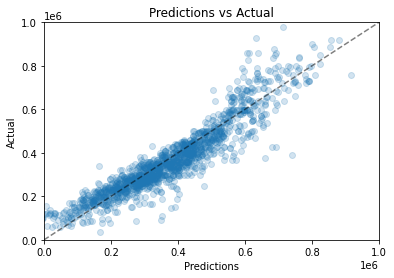

In [181]:
plt.plot([0, 1_000_000], [0, 1_000_000], color="black", alpha=0.5, linestyle="--")

predicted_price_array = df_test["Predicted_price"].values
actual_price_array = df_test["Price"].values
plt.scatter(predicted_price_array, actual_price_array, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")

plt.xlim(0, 1_000_000)
plt.ylim(0, 1_000_000)
plt.show()